### 1.0 -Load libraries
In our Second Hand Car Price Prediction project we used SXBoost, mada score

In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # library for visualization
import seaborn as sns # library for visualization
import warnings
from sklearn.ensemble import RandomForestRegressor
import os
from sklearn.preprocessing import StandardScaler
import csv 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

warnings.filterwarnings('ignore')
sns.set_palette('Spectral')
sns.set_context('notebook', font_scale=1)
sns.set_style('whitegrid')
# set pandas 3 digits decimal
pd.set_option('display.float_format', '{:.3f}'.format)

<p> Note to self: <br>
1- Load the initial data, clean car data that can cause false calculations. + <br>
2- Fill, complete missing values +<br>
3- Change all data into numerical values. <--- <br>
4- Try the ML algorithms: KNN, Kmean clustering, XGBoost... <br>
5- Start building the web app
</p>

<h4> 1.1 Load the available data </h4>

In [10]:
dir = 'dataset-cleaned-normalized.csv'
with open(dir, mode='r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader, None)
    
# print first 5 recording of data
df=pd.read_csv(dir)
df.columns = df.columns.str.lower()  # Convert all column names to lowercase
print(df.head(3))
print()
print(df.columns)


                                  name  year  odometer fuel_type transmission  \
0  'Audi Q7 45 TDI Quattro Technology' 0.905     0.009    Diesel    Automatic   
1     'Mercedes-Benz GLC 43 AMG Coupe' 0.952     0.003    Petrol    Automatic   
2             'Mercedes-Benz GLE 350d' 0.905     0.005    Diesel    Automatic   

   mileage  engine  power  seats  price_usd  
0    0.440   0.436  0.401  0.700     119904  
1    0.343   0.441  0.633  0.500     114456  
2    0.345   0.440  0.420  0.500     114156  

Index(['name', 'year', 'odometer', 'fuel_type', 'transmission', 'mileage',
       'engine', 'power', 'seats', 'price_usd'],
      dtype='object')


#### 1.2 APPEND data from internet and append the data to available data

This is done to increase amount of data and to increase coherence.

## HANDLING MISSING VALUES

Skewness: 58.59887227765106


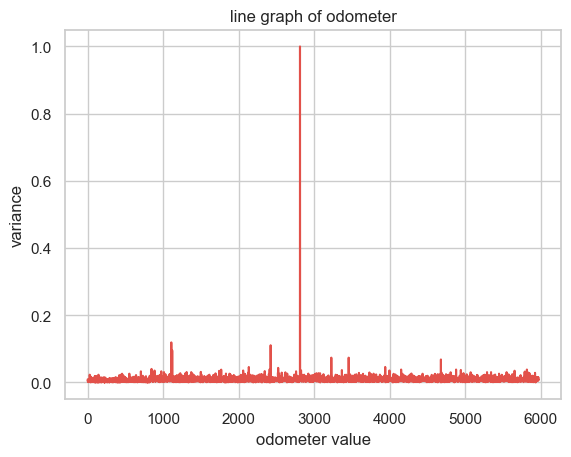

year        -0.842
odometer    58.599
mileage     -0.351
engine       1.425
power        1.933
seats        1.835
price_usd    3.086
dtype: float64


In [11]:
skewness = df['odometer'].skew()
print(f"Skewness: {skewness}")
df['odometer'].plot(kind='line')
plt.title('line graph of odometer')
plt.xlabel('odometer value')
plt.ylabel('variance')
plt.show()
df['odometer'] = df['odometer'].fillna(df['odometer'].median()) # HANDLING FOR SKEWED DATA
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
print(df[numerical_cols].skew())

df['year'] = df['year'].fillna(df['year'].mean()) # HANDLING FOR SYMMETRIC DATA

<h4> FILLING MISSING VALUES FOR CATEGORICAL DATA </h4>

Dataset columns: ['Name', 'Year', 'Odometer', 'Fuel_Type', 'Transmission', 'Mileage', 'Engine', 'Power', 'Seats', 'Price_usd']

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5975 entries, 0 to 5974
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          5975 non-null   object 
 1   Year          5975 non-null   float64
 2   Odometer      5975 non-null   float64
 3   Fuel_Type     5975 non-null   object 
 4   Transmission  5975 non-null   object 
 5   Mileage       5975 non-null   float64
 6   Engine        5975 non-null   float64
 7   Power         5975 non-null   float64
 8   Seats         5975 non-null   float64
 9   Price_usd     5975 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 466.9+ KB
None

First few rows:
                                  Name  Year  Odometer Fuel_Type Transmission  \
0  'Audi Q7 45 TDI Quattro Technology' 0.905     0.009    Diesel    

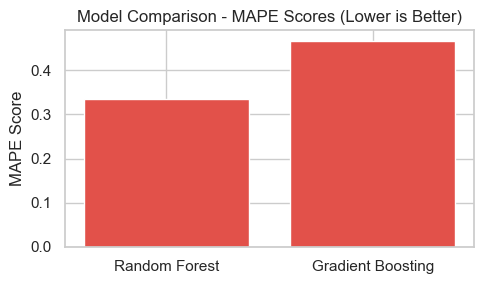


Best performing model: Random Forest with MAPE: 33.60%


In [12]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="Found unknown categories")

# Load the new dataset
df = pd.read_csv('dataset-cleaned-normalized.csv')

# First, let's examine the dataset to understand its structure
print("Dataset columns:", df.columns.tolist())
print("\nDataset info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

# Identify numerical and categorical columns based on data types
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Remove the target variable from features if it exists
target_column = 'Price_usd'  # Adjust this if your target column has a different name
if target_column in numerical_features:
    numerical_features.remove(target_column)

print(f"\nNumerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ] if categorical_features else [('num', StandardScaler(), numerical_features)]
)

# Split the data
X = df[numerical_features + categorical_features]
y = df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Train Random Forest with default parameters first
print("\nTraining Random Forest with default parameters...")
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
rf_mape = mean_absolute_percentage_error(y_test, y_pred_rf)
print(f"Random Forest Default MAPE: {rf_mape:.2%}")

# 2. Train Gradient Boosting with default parameters
print("\nTraining Gradient Boosting with default parameters...")
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

gb_pipeline.fit(X_train, y_train)
y_pred_gb = gb_pipeline.predict(X_test)
gb_mape = mean_absolute_percentage_error(y_test, y_pred_gb)
print(f"Gradient Boosting Default MAPE: {gb_mape:.2%}")

# Compare the models
models = {
    'Random Forest': rf_mape,
    'Gradient Boosting': gb_mape
}

# Visualize results
plt.figure(figsize=(5, 3))
plt.bar(models.keys(), models.values())
plt.title('Model Comparison - MAPE Scores (Lower is Better)')
plt.ylabel('MAPE Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Determine the best model
best_model_name = min(models.items(), key=lambda x: x[1])[0]
best_mape = min(models.values())
print(f"\nBest performing model: {best_model_name} with MAPE: {best_mape:.2%}")

### EXTRA/ Analyzing data

### 4.0 MACHINE LEARNING

#### K-means clustering

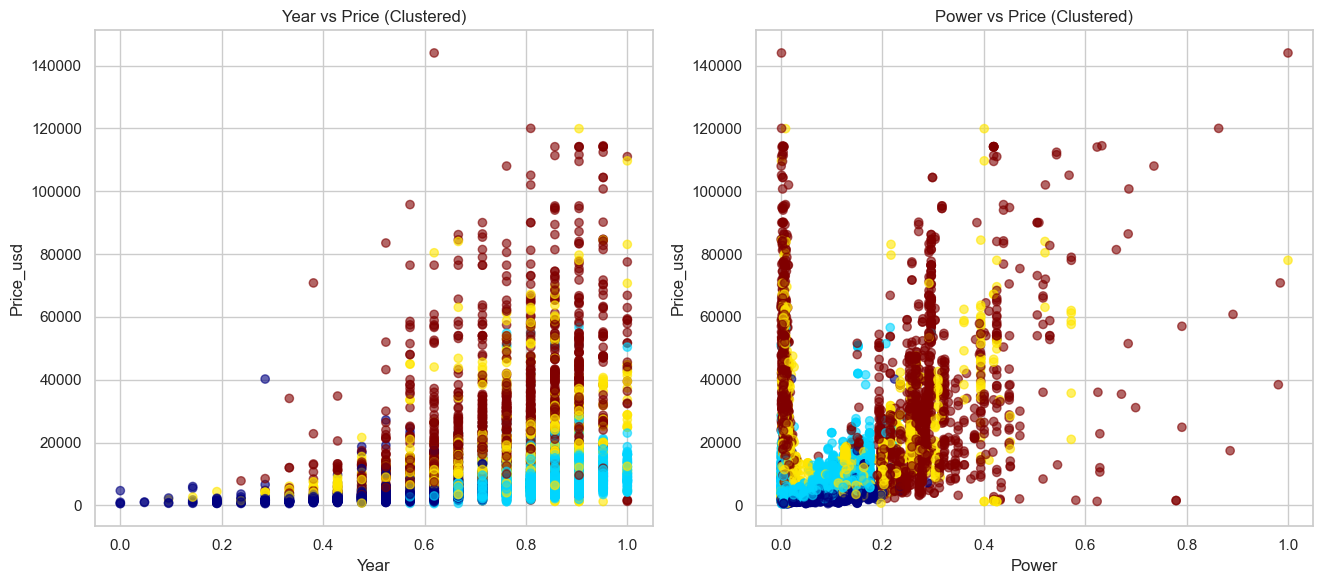


Cluster Statistics:

Cluster 0:
Number of cars: 1290
Average price: $3,834.65
Average year: 0.5485
Average odometer: 0.0113
Average Power: 0.1055

Cluster 1:
Number of cars: 2831
Average price: $7,686.29
Average year: 0.8137
Average odometer: 0.0072
Average Power: 0.0982

Cluster 2:
Number of cars: 757
Average price: $17,714.76
Average year: 0.7408
Average odometer: 0.0131
Average Power: 0.2071

Cluster 3:
Number of cars: 1097
Average price: $31,548.40
Average year: 0.7347
Average odometer: 0.0081
Average Power: 0.2986


In [13]:
# Load the data
df = pd.read_csv('dataset-cleaned-normalized.csv')

X = df[numerical_features]
y = df['Price_usd']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-means clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df['Cluster'] = cluster_labels

# Create visualization subplots
fig = plt.figure(figsize=(20, 6))

# Plot 1: Year vs Price
plt.subplot(1, 3, 1)
scatter1 = plt.scatter(df['Year'], df['Price_usd'],c=cluster_labels, cmap='jet', alpha=0.6)
plt.xlabel('Year')
plt.ylabel('Price_usd')
plt.title('Year vs Price (Clustered)')
#plt.colorbar(scatter1, label='Cluster')

# Plot 2: Odometer vs Price
plt.subplot(1, 3, 2)
scatter2 = plt.scatter(df['Odometer'], df['Price_usd'],c=cluster_labels, cmap='jet', alpha=0.6)
plt.xlabel('Odometer')
plt.ylabel('Price_usd')
plt.title('Odometer vs Price (Clustered)')
#plt.colorbar(scatter2, label='Cluster')

plt.subplot(1, 3, 2)
scatter2 = plt.scatter(df['Power'], df['Price_usd'],c=cluster_labels, cmap='jet', alpha=0.6)
plt.xlabel('Power')
plt.ylabel('Price_usd')
plt.title('Power vs Price (Clustered)')
#plt.colorbar(scatter2, label='Cluster')

plt.tight_layout()
plt.show()

# Print cluster statistics
print("\nCluster Statistics:")
for cluster in range(n_clusters):
    cluster_data = df[df['Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"Number of cars: {len(cluster_data)}")
    print(f"Average price: ${cluster_data['Price_usd'].mean():,.2f}")
    print(f"Average year: {cluster_data['Year'].mean():.4f}")
    print(f"Average odometer: {cluster_data['Odometer'].mean():.4f}")
    print(f"Average Power: {cluster_data['Power'].mean():.4f}")
   # Load the data
df = pd.read_csv('dataset-cleaned-normalized.csv')

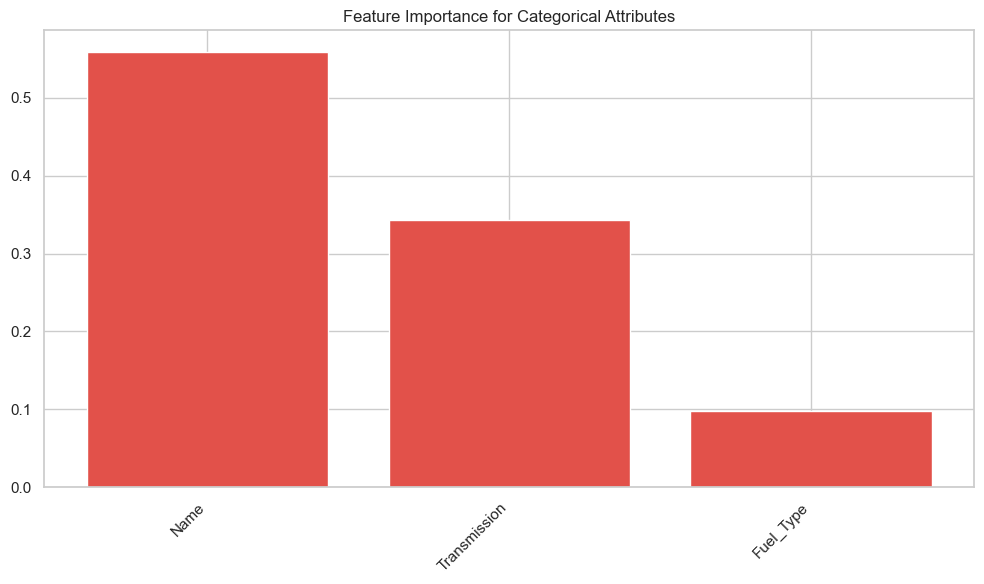


Feature Importances:
        Feature  Importance
0          Name       0.559
2  Transmission       0.343
1     Fuel_Type       0.098


In [14]:
# Load the data
df = pd.read_csv('dataset-cleaned-normalized.csv')

# Select only categorical features
#categorical_features = ['year', 'manufacturer', 'model', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color']
categorical_features = ['Name','Fuel_Type','Transmission']
#numerical_features = ['Year', 'Mileage','Engine','Power','Seats']
# Create X (features) and y (target)
X = df[categorical_features]
y = df['Price_usd']

# Convert categorical variables to numerical using Label Encoding
label_encoders = {}
X_encoded = X.copy()
for column in categorical_features:
    label_encoders[column] = LabelEncoder()
    X_encoded[column] = label_encoders[column].fit_transform(X[column])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Calculate and display feature importances
importances = pd.DataFrame({
    'Feature': categorical_features,
    'Importance': rf_model.feature_importances_
})
importances = importances.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(importances['Feature'], importances['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance for Categorical Attributes')
plt.tight_layout()
plt.show()

# Print feature importances
print("\nFeature Importances:")
print(importances)

In [15]:
# Import additional library
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load and prepare the data
df = pd.read_csv('dataset-cleaned-normalized.csv')

# Separate features
numerical_features = ['Year', 'Odometer', 'Mileage','Engine','Power','Seats','Price_usd']
categorical_features = ['Name','Fuel_Type','Transmission']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

# Split the data
X = df[numerical_features + categorical_features]
y = df['Price_usd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and evaluate multiple models
models = {
    'KNN': KNeighborsRegressor(n_neighbors=4),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Train model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_test, y_pred)
    results[name] = mape
    
    print(f"\n{name} Results:")
    print(f"MAPE: {mape:.2%}")
# Find best model
best_model = min(results.items(), key=lambda x: x[1])
print(f"\nBest performing model: {best_model[0]} with MAPE: {best_model[1]:.2%}")


KNN Results:
MAPE: 20.60%

Random Forest Results:
MAPE: 0.08%

Gradient Boosting Results:
MAPE: 0.97%

XGBoost Results:
MAPE: 0.75%

Best performing model: Random Forest with MAPE: 0.08%


#### Random forest -> Tuning -> Gradient Boosting


Numerical features: ['Year', 'Odometer', 'Mileage', 'Engine', 'Power', 'Seats']
Categorical features: ['Name', 'Fuel_Type', 'Transmission']

Performing 10-fold cross-validation...
Random Forest - Fold 1: MAPE = 0.3766, R² = 0.8053
Random Forest - Fold 2: MAPE = 0.2501, R² = 0.9208
Random Forest - Fold 3: MAPE = 0.1875, R² = 0.8742
Random Forest - Fold 4: MAPE = 0.3621, R² = 0.8205
Random Forest - Fold 5: MAPE = 0.2953, R² = 0.8326
Random Forest - Fold 6: MAPE = 0.1974, R² = 0.8995
Random Forest - Fold 7: MAPE = 0.4028, R² = 0.7814
Random Forest - Fold 8: MAPE = 0.2731, R² = 0.8476
Random Forest - Fold 9: MAPE = 0.2859, R² = 0.8880
Random Forest - Fold 10: MAPE = 0.2187, R² = 0.9261
Gradient Boosting - Fold 1: MAPE = 0.5117, R² = 0.7508
Gradient Boosting - Fold 2: MAPE = 0.4187, R² = 0.8489
Gradient Boosting - Fold 3: MAPE = 0.3113, R² = 0.8312
Gradient Boosting - Fold 4: MAPE = 0.5105, R² = 0.7576
Gradient Boosting - Fold 5: MAPE = 0.4235, R² = 0.7898
Gradient Boosting - Fold 6: MAPE 

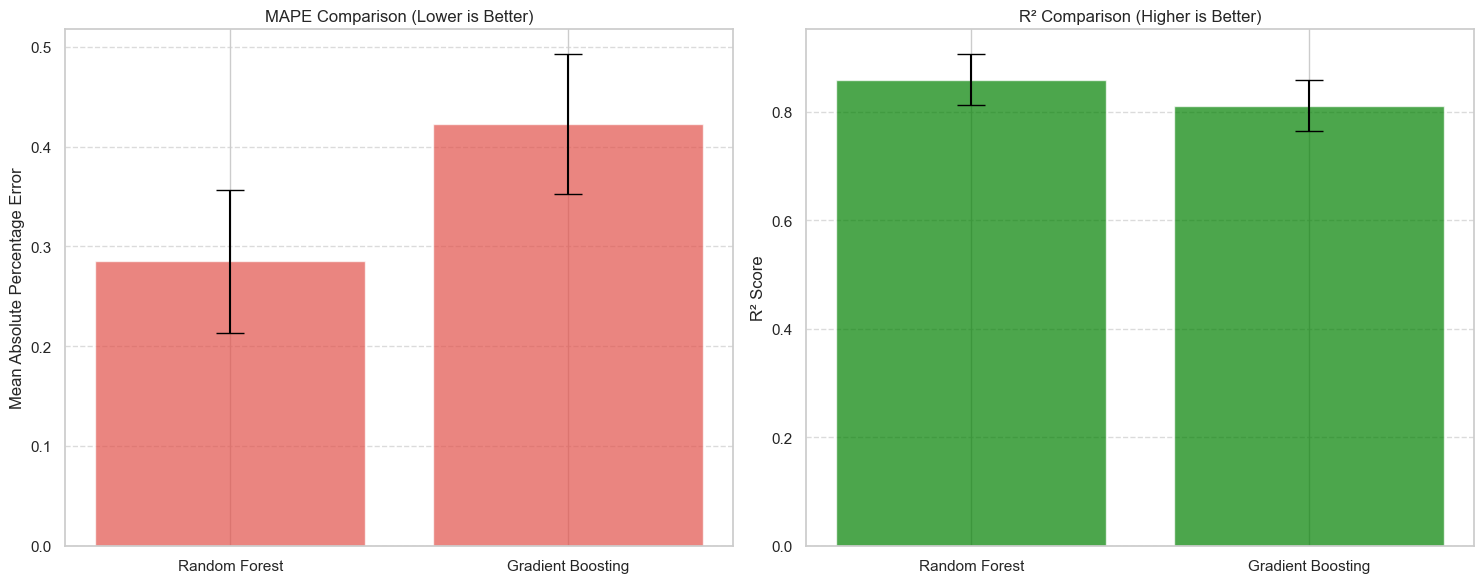


Best performing model: Random Forest
Average MAPE: 0.2849
Average R²: 0.8596


In [20]:
# Import additional libraries for cross-validation and R-squared
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score

# Load the dataset
df = pd.read_csv('dataset-cleaned-normalized.csv')

# Identify numerical and categorical columns based on data types
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Remove the target variable from features if it exists
target_column = 'Price_usd'  # Adjust this if your target column has a different name
if target_column in numerical_features:
    numerical_features.remove(target_column)

print(f"\nNumerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ] if categorical_features else [('num', StandardScaler(), numerical_features)]
)

# Prepare data
X = df[numerical_features + categorical_features]
y = df[target_column]

# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Create pipelines
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Dictionary to store results
cv_results = {
    'Random Forest': {'MAPE': [], 'R2': []},
    'Gradient Boosting': {'MAPE': [], 'R2': []}
}

# Perform 10-fold cross-validation
print("\nPerforming 10-fold cross-validation...")

# Function to evaluate models with cross-validation
def evaluate_model(model, model_name):
    fold = 1
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mape = mean_absolute_percentage_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        cv_results[model_name]['MAPE'].append(mape)
        cv_results[model_name]['R2'].append(r2)
        
        print(f"{model_name} - Fold {fold}: MAPE = {mape:.4f}, R² = {r2:.4f}")
        fold += 1

# Evaluate Random Forest
evaluate_model(rf_pipeline, 'Random Forest')

# Evaluate Gradient Boosting
evaluate_model(gb_pipeline, 'Gradient Boosting')

# Calculate average metrics
for model_name in cv_results:
    avg_mape = np.mean(cv_results[model_name]['MAPE'])
    avg_r2 = np.mean(cv_results[model_name]['R2'])
    std_mape = np.std(cv_results[model_name]['MAPE'])
    std_r2 = np.std(cv_results[model_name]['R2'])
    
    print(f"\n{model_name} - Average MAPE: {avg_mape:.4f} ± {std_mape:.4f}")
    print(f"{model_name} - Average R²: {avg_r2:.4f} ± {std_r2:.4f}")

# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# MAPE comparison
model_names = list(cv_results.keys())
mape_means = [np.mean(cv_results[model]['MAPE']) for model in model_names]
mape_stds = [np.std(cv_results[model]['MAPE']) for model in model_names]

ax1.bar(model_names, mape_means, yerr=mape_stds, capsize=10, alpha=0.7)
ax1.set_title('MAPE Comparison (Lower is Better)')
ax1.set_ylabel('Mean Absolute Percentage Error')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# R² comparison
r2_means = [np.mean(cv_results[model]['R2']) for model in model_names]
r2_stds = [np.std(cv_results[model]['R2']) for model in model_names]

ax2.bar(model_names, r2_means, yerr=r2_stds, capsize=10, alpha=0.7, color='green')
ax2.set_title('R² Comparison (Higher is Better)')
ax2.set_ylabel('R² Score')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Determine the best model based on MAPE
best_model_idx = np.argmin([np.mean(cv_results[model]['MAPE']) for model in model_names])
best_model_name = model_names[best_model_idx]
best_mape = np.mean(cv_results[best_model_name]['MAPE'])
best_r2 = np.mean(cv_results[best_model_name]['R2'])

print(f"\nBest performing model: {best_model_name}")
print(f"Average MAPE: {best_mape:.4f}")
print(f"Average R²: {best_r2:.4f}")

### 5.0 NEURAL NETWORK

In [12]:
# neural_model.py
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import pickle
import warnings
warnings.filterwarnings('ignore')

print("Loading data...")
# Load the data
df = pd.read_csv('dataset-cleaned-normalized.csv')

# Identify numerical and categorical columns
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Remove target column from features
target_column = 'Price_usd'  # Adjust this if your target column has a different name
if target_column in numerical_features:
    numerical_features.remove(target_column)

print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ] if categorical_features else [('num', StandardScaler(), numerical_features)]
)

# Prepare data
X = df[numerical_features + categorical_features]
y = df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training neural network model...")
# Create neural network pipeline
nn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        max_iter=612,
        early_stopping=True,
        validation_fraction=0.2,
        random_state=42,
        verbose=True
    ))
])

# Train the model
nn_pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = nn_pipeline.predict(X_test)
mape = 100 * mean_absolute_percentage_error(y_test, y_pred)
r2 = 100 * r2_score(y_test, y_pred)

print(f"Neural Network MAPE: % {mape:.2f}")
print(f"Neural Network R²: % {r2:.2f}")

# Save the model
print("Saving model...")
with open('nn_model.pkl', 'wb') as f:
    pickle.dump(nn_pipeline, f)

print("Model training and saving complete!")

Loading data...
Numerical features: ['Year', 'Odometer', 'Mileage', 'Engine', 'Power', 'Seats']
Categorical features: ['Name', 'Fuel_Type', 'Transmission']
Training neural network model...


InvalidParameterError: The 'solver' parameter of MLPRegressor must be a str among {'sgd', 'adam', 'lbfgs'}. Got 'rmsprop' instead.

#### APP RUN 